# APMTH 207: Advanced Scientific Computing: 
## Spencer Hallyburton
## Collaborator: Salvador Barragan
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, April 7th, 2018 at 10:59am

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pymc3 as pm
from math import erf

In [2]:
import itertools

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

This Homework is a continuation of Problem #1 from Homework 8.

Your answers to Problem #1 from HW8 should  give you a idea of how one might create or select a model for a particular application and your answers will help you with formalizing the model in this Homework, which is much more technically involved.


## Problem #1: Modeling Your Understanding

In the dataset "reviews_processed.csv", you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in Problem #1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for Problem #1.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to Part A and B:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to Extra Credit:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="restuarant_model.pdf">

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*



In [3]:
# Load in the data:
rest_data = pd.read_csv('reviews_processed.csv')
print('Number of Reviews:', rest_data.shape[0])
print('Number of Unique Reviewers:', rest_data['review_id'].nunique())
print('Number of Unique Restaurants:', rest_data['rid'].nunique())
rest_data.head()

Number of Reviews: 147914
Number of Unique Reviewers: 88972
Number of Unique Restaurants: 11417


,review_id,topic,rid,count,max,mean,min,stars,uavg,var
0,---sV8KdwfBoDw38KW_WnQ,0,VgLiSW1iGkpzIEXOgvUBEw,5,0.689383,0.558430,0.312919,3,3.285714,0.024112
1,---sV8KdwfBoDw38KW_WnQ,1,VgLiSW1iGkpzIEXOgvUBEw,5,0.816901,0.554300,0.211441,3,3.285714,0.050309
2,--0MzHNy7MVBRvZCOAeRPg,0,4gLecengX1JeGILm7DwU3w,3,0.746711,0.574416,0.360240,5,3.829268,0.038655
3,--0MzHNy7MVBRvZCOAeRPg,1,4gLecengX1JeGILm7DwU3w,6,0.848065,0.657755,0.476156,5,3.829268,0.014583
4,--2NT40xmHh9oBLumzdjhA,0,4ZZab5hinFzHtj3sE8vQWg,5,0.764218,0.601008,0.337710,2,4.181818,0.026742


In [4]:
# Replace all instances of zero for variance with the maximum variance:
rest_data.loc[rest_data['var']==0, 'var'] = rest_data['var'].median()

### Part A: Modeling

When the value in "count" is low, the "mean" value can be very skewed.

Following the [SAT prep school example discussed in lab](https://am207.github.io/2018spring/wiki/gelmanschoolstheory.html) (and using your answers for HW 8 Problem #1), set up a Bayesian model(that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service, separately. That is, you will have a model for each restaurant and each aspect (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** what quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?



### ANSWER: Part A
In the data provided, we can naturally think of each review as a school and as each sentence in a review as a student. Therefore, we want to create a model for each restaurant, and within each restaurant, create a model for both food and service. Thus, the sentence level mean scores naturally correspond to the $\bar{y}_j$'s. We can then obtain the standard error estimates by taking the variance of the scores and dividing by the number of sentences. This performs the function of a bootstrap.

In [5]:
# Add another column for standard error estimate of the mean:
rest_data['stderr'] = np.sqrt(rest_data['var']/rest_data['count'])

Now we can write the likelihood for each parameter $\theta_j$ using the means:
$$
\bar{y_j}\mid\theta_j \sim N(\theta_j, \sigma_j^2)
$$

Now let's choose one restaurant, build a model for one aspect, then construct the general process using functions. Here is our general model in a non-centered parameterization to reduce steepness and curvature:

$$
\mu \sim \mathcal{N}(.5, .1)\\
\tau \sim \text{Half-Cauchy}(.15)\\
\nu_j \sim \mathcal{N}(0, 1)\\
\theta_j = \mu + \tau\nu_j\\
\bar{y_j} \sim \mathcal{N}(\theta_j, \sigma_j)
$$

In [6]:
def perform_sampling_rest(data_input):
    J = data_input.shape[0]
    
    # Create model
    with pm.Model() as review_model:
        mu = pm.Normal('mu', mu=.5, sd=.1) # This is mean of theta
        tau = pm.HalfCauchy('tau', beta=.15) # This is SD of theta
        nu = pm.Normal('nu', mu=0, sd=1, shape=J) # Keep this as N(0,1)
        theta = pm.Deterministic('theta', mu + tau * nu)
        obs = pm.Normal('obs', mu=theta, sd=data_input['stderr'], observed=data_input['mean'])
        
    # Sample with pymc3
    with review_model:
        traces = pm.sample(5000, init=None, njobs=2, tune=500)
        
    # Calculate the theta mean and variance:
    thmean = traces['theta'].mean(axis=0)
    thvar = traces['theta'].var(axis=0)
    
    return (traces, thmean, thvar, review_model)

In [7]:
# Try this model for one restaurant
rid_one = rest_data['rid'].mode()[0]
data_1 = rest_data[(rest_data['topic']==0) & (rest_data['rid']==rid_one)]
traces1, thmean1, thvar1, reviews1 = perform_sampling_rest(data_1)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:20<00:00, 273.44it/s]
The acceptance probability does not match the target. It is 0.889579940373, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11416ddd8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1142e46a0>]], dtype=object)

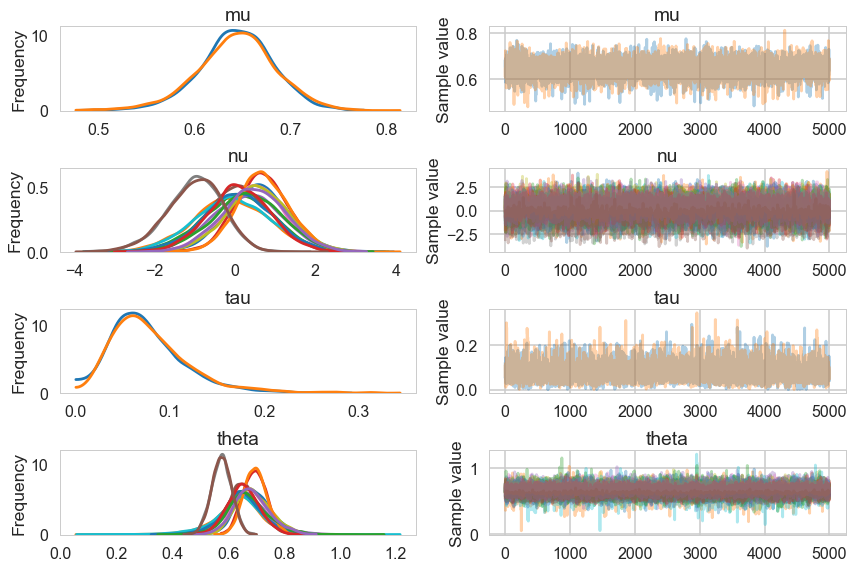

In [8]:
# Make a traceplot
pm.traceplot(traces1)

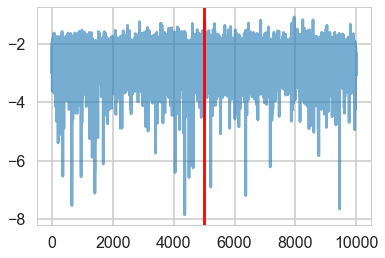

In [9]:
# Show one of the traces
plt.plot(traces1['tau_log__'], alpha=0.6)
plt.axvline(5000, color="r")

In [10]:
# Show diagnostics
pm.diagnostics.gelman_rubin(traces1), pm.diagnostics.effective_n(traces1)

({'mu': 1.0000764756899345,
  'nu': array([ 0.99990802,  1.00012416,  0.99991482,  1.00000096,  0.99997913,
          0.9999085 ,  0.99990226,  1.00017376]),
  'tau': 1.0029857224008514,
  'theta': array([ 1.00012813,  0.99990071,  0.9999236 ,  1.00042902,  1.00000078,
          0.99990567,  0.99990846,  1.00002114])},
 {'mu': 3988.0,
  'nu': array([  8789.,   9141.,   9624.,   6397.,  10000.,   9420.,  10000.,
           5232.]),
  'tau': 2740.0,
  'theta': array([  9065.,   5452.,   8782.,  10000.,   9058.,  10000.,  10000.,
           7169.])})

In [11]:
# Show divergences
logtau = traces1['tau_log__']
mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
divergent = traces1['diverging']
print('Number of Divergent %d' % divergent.nonzero()[0].size)
divperc = divergent.nonzero()[0].size/len(traces1)
print('Percentage of Divergent %.5f' % divperc)

Number of Divergent 2
Percentage of Divergent 0.00040


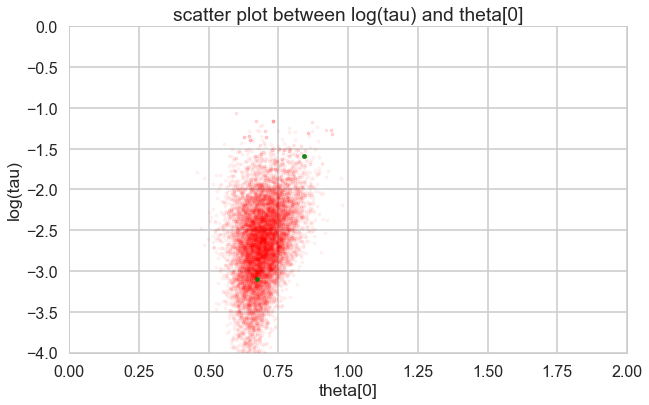

In [12]:
# Show where divergences occur
theta_trace = traces1['theta']
theta0 = theta_trace[:, 0]
plt.figure(figsize=(10, 6))
plt.scatter(theta0[divergent == 0], logtau[divergent == 0], color='r', s=10, alpha=0.05)
plt.scatter(theta0[divergent == 1], logtau[divergent == 1], color='g', s=20, alpha=0.9)
plt.axis([-0, 2, -4, 0])
plt.ylabel('log(tau)')
plt.xlabel('theta[0]')
plt.title('scatter plot between log(tau) and theta[0]')
plt.show()

In [13]:
with reviews1:
    ppc_1 = pm.sample_ppc(traces1, 1000)

100%|██████████| 1000/1000 [00:00<00:00, 2463.09it/s]


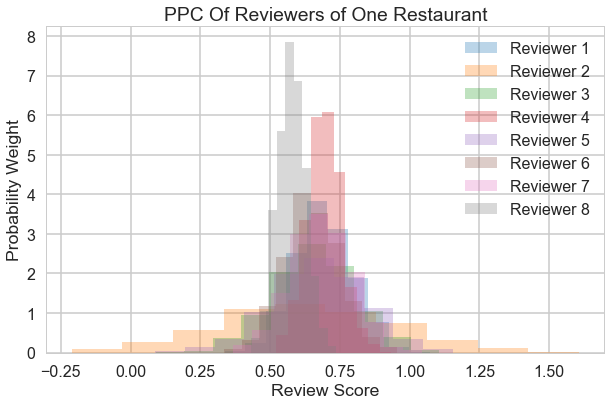

In [14]:
with sns.plotting_context("poster"):
    fig = plt.figure(figsize=(10,6))
    [plt.hist(ppc_1['obs'][:,i], alpha=0.3,normed=True, label='Reviewer %d'%(i+1)) for i in range(len(ppc_1['obs'][0]))]
    plt.xlabel('Review Score')
    plt.ylabel('Probability Weight')
    plt.title('PPC Of Reviewers of One Restaurant')
    plt.legend()

### Part B: Analysis for Each restaurant

Use your model to produce estimates for $\theta_{jk}$'s. Pick a few restaurants, for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the same restaurants, for each aspect, generate shrinkage plots and probability shrinkage plots as follows:

In [15]:
# Write a loop to do a few restaurants and generate estimates for theta
import collections

unique_rids = rest_data['rid'].value_counts().keys().tolist()
counts = rest_data['rid'].value_counts().tolist()

nrest = 10 # Total number of restaurants

# Get the unique count numbers
unique_counts = list(set(counts))

# Sample the unique countvals randomly
countvals_to_get = np.random.choice(unique_counts, size=nrest, replace=True)

# Do it again if I ask for more than one 6 value
while len(np.where(countvals_to_get==6)[0]) == 2:
    countvals_to_get = np.random.choice(unique_counts, size=nrest, replace=True)

# Do a count on these countvals
countval_counter = collections.Counter(countvals_to_get)

# Loop over each of these key and values
rids = []
for ele in countval_counter:
    
    # Get a list of RIDs with this count
    rids_this_count = [unique_rids[i] for i, c in enumerate(counts) if c == ele]
    
    # Get 10 of these
    rid_vals = np.random.choice(rids_this_count, size=countval_counter[ele], replace=False)
    rids= np.concatenate((rids, rid_vals))

In [16]:
# Initialize storage dataframe
df_list_food = []
df_list_serve = []

# Loop over all of these RIDs
for i, rid_in in enumerate(rids):
    # Do the food one:
    data_food = rest_data[(rest_data['topic']==0) & (rest_data['rid']==rid_in)]
    _, thm_f, thv_f, _ = perform_sampling_rest(data_food)
    # Concatentate the original and the estimated data
    df_f = pd.DataFrame(data={'th_mean': thm_f, 'th_var': thv_f})
    data_food.reset_index(drop=True, inplace=True)
    df_f.reset_index(drop=True, inplace=True)
    data_out_food = pd.concat([data_food,df_f], axis=1)
    df_list_food.append(data_out_food)
    
    # Do the service one:
    data_serve = rest_data[(rest_data['topic']==1) & (rest_data['rid']==rid_in)]
    _, thm_s, thv_s, _ = perform_sampling_rest(data_serve)
    # Concatentate the original and the estimated data
    df_s = pd.DataFrame(data={'th_mean': thm_s, 'th_var': thv_s})
    data_serve.reset_index(drop=True, inplace=True)
    df_s.reset_index(drop=True, inplace=True)
    data_out_serve = pd.concat([data_serve,df_s], axis=1)
    df_list_serve.append(data_out_serve)
    

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:29<00:00, 185.42it/s]
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:17<00:00, 306.06it/s]
There were 137 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.686956377381, but should be close to 0.8. Try to increase the number of tuning steps.
There were 57 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:19<00:00, 286.41it/s]
Th

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


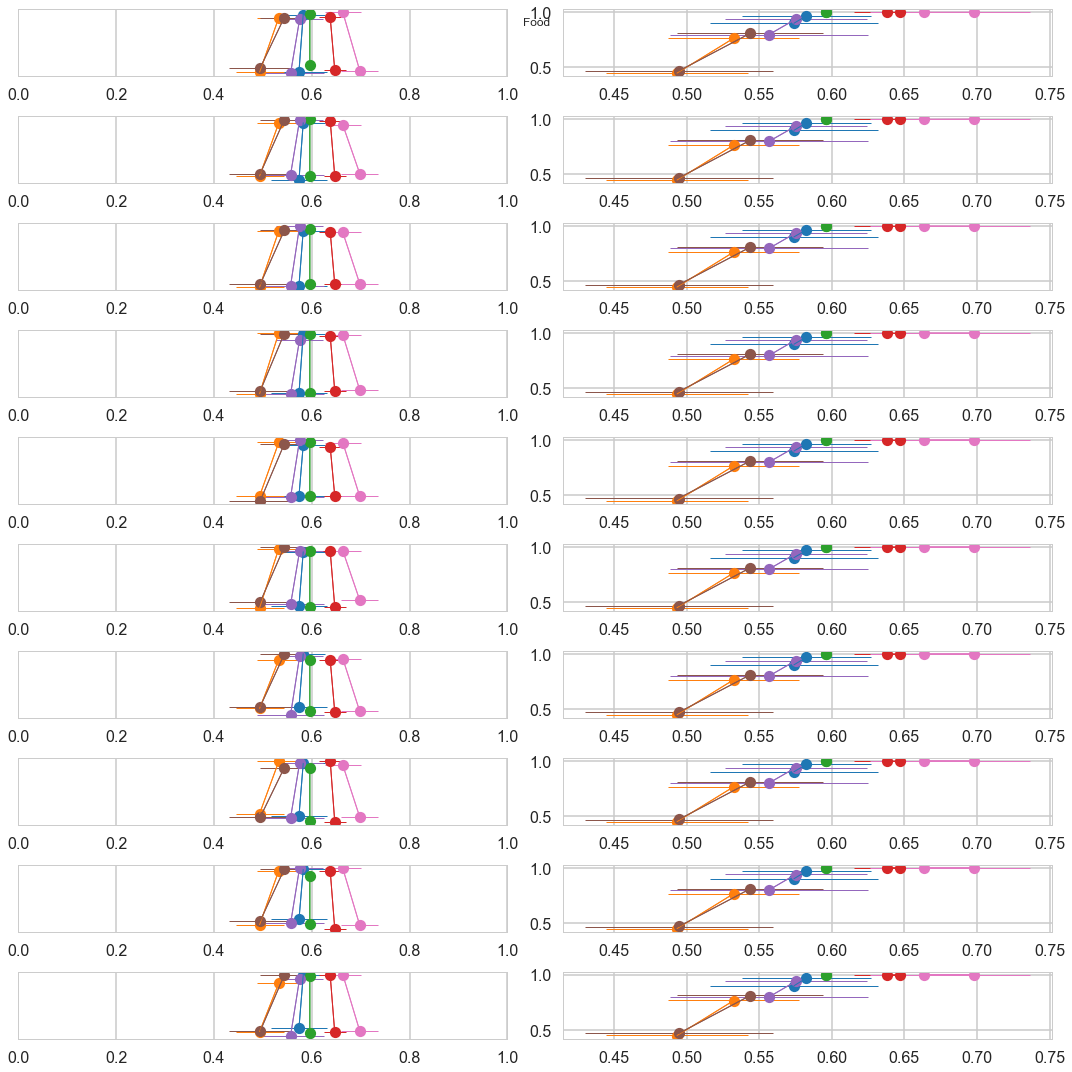

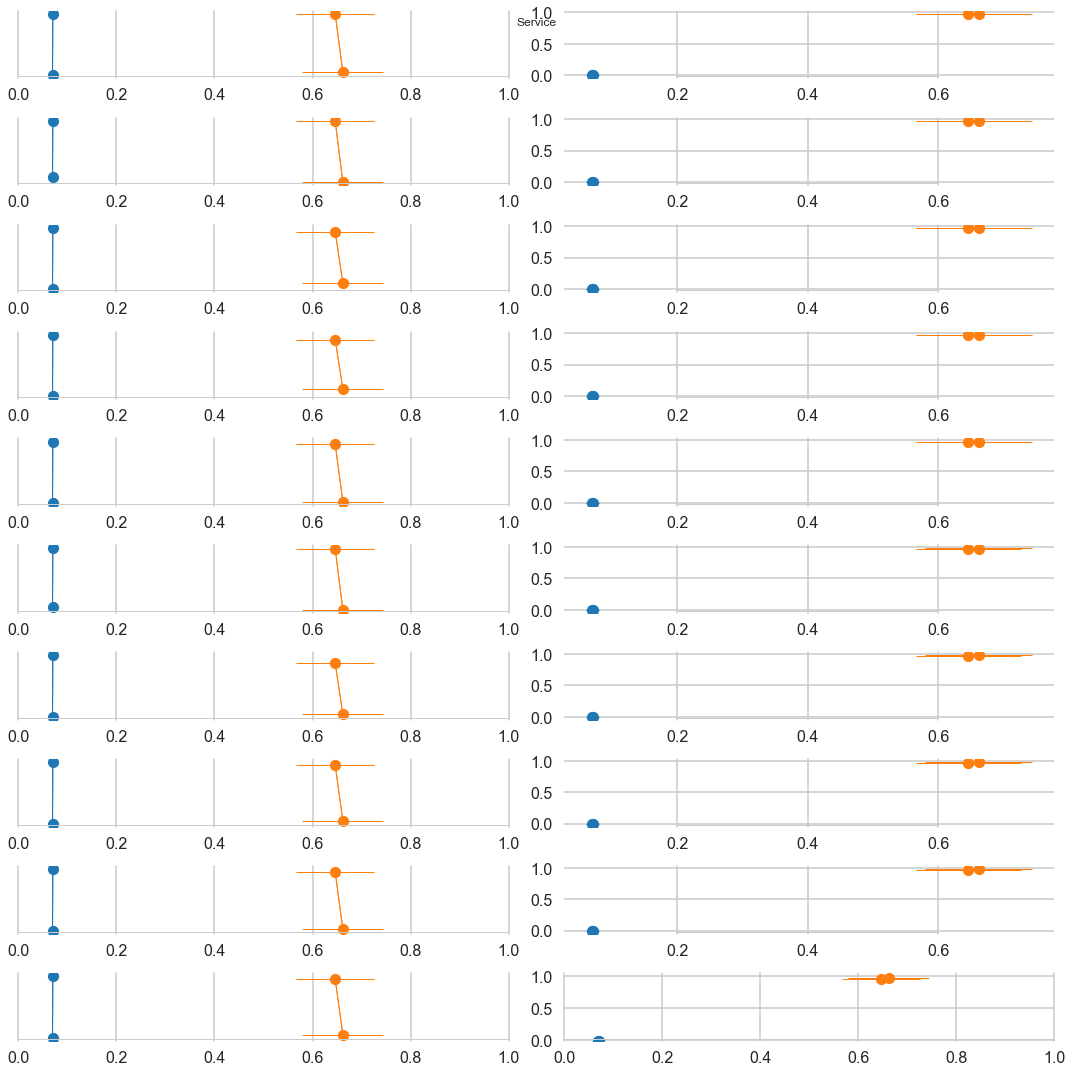

In [17]:
# Create the shrinkage plot for each restaurant
fig_f, ax_f = plt.subplots(len(rids), 2, figsize=(15,15))
fig_s, ax_s = plt.subplots(len(rids), 2, figsize=(15,15))

for idx in range(len(rids)):
    # Plot food data
    d_food = df_list_food[i]
    shrinkage_plot(d_food['mean'].values, d_food['th_mean'].values, d_food['var'].values,
                   d_food['th_var'].values, d_food['count'].values, ax=ax_f[idx,0])
    
    prob_shrinkage_plot(d_food['mean'].values, d_food['th_mean'].values, d_food['var'].values,
                   d_food['th_var'].values, d_food['count'].values, ax=ax_f[idx,1])
    
    # Plot service data
    d_serve = df_list_serve[i]
    shrinkage_plot(d_serve['mean'].values, d_serve['th_mean'].values, d_serve['var'].values,
                   d_serve['th_var'].values, d_serve['count'].values, ax=ax_s[idx,0])
    
    prob_shrinkage_plot(d_serve['mean'].values, d_serve['th_mean'].values, d_serve['var'].values,
                   d_serve['th_var'].values, d_serve['count'].values, ax=ax_s[idx,1])
fig_f.suptitle('Food')
fig_f.tight_layout()
fig_f.show()

fig_s.suptitle('Service')
fig_s.tight_layout()
fig_s.show()

In the shrinkage plots above, we see that, in the left plots, the values for theta estimates are pulled towards a mean value. This mean value comes from the pooling of the theta estimates. This is shrinkage in action, as a partial pooling serves to smooth extrema in the data. In particular, we see that low rating means are pulled up towards a mean value, while high theta values are pulled down. In the right plots, we see a smoothing also of the probability that each review is classified as a 1 (i.e. good). We can match the x-axis from the plots on the left to the probability plots on the right to state that low probability scores are pulled up towards some mean value.

In terms of the statistical benefits of this kind of approach, we can state that this model takes more into account the information across the entire set of data, whereas the mean value of the data for each reviewer is highly dependent on that one reviewer and has no information about the rest of the data.

### Part C: Analysis Across Restaurants

Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. Discuss the statistical weakness of ranking by these scores.

(**Hint:** what is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? You've seen this question addressed a number of times in previous homeworks. This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)


In [18]:
(rest_data['mean']*rest_data['uavg'] ).mean()

2.344685440951948

In [19]:
def generate_rankings(df_list_food, df_list_serve, adjust=0):
    # Map score values:
    rids = list(map(lambda df: df['rid'][0], df_list_food))

    # Make adjustments if asked:
    if adjust:
        new_exp = lambda df: (df['mean'] * df['uavg'] ) / df['uavg'].mean()
        means_food = list(map(lambda df: (new_exp(df)).mean(), df_list_food))
        vars_food = list(map(lambda df: (new_exp(df)).var(), df_list_food))
        means_serve = list(map(lambda df: (new_exp(df)).mean(), df_list_serve))
        vars_serve = list(map(lambda df: (new_exp(df)).var(), df_list_serve))    
    else: #Normal calculation:
        means_food = list(map(lambda df: df['mean'].mean(), df_list_food))
        vars_food = list(map(lambda df: df['mean'].var(), df_list_food))
        means_serve = list(map(lambda df: df['mean'].mean(), df_list_serve))
        vars_serve = list(map(lambda df: df['mean'].var(), df_list_serve))
    
    # Food
    plt.errorbar(list(range(len(rids))), means_food, yerr=vars_food, capsize=10, fmt='o', label='Food')
    # Service
    plt.errorbar(list(range(len(rids))), means_serve, yerr=vars_serve, capsize=10, fmt='o', label='Service')
    plt.title('Mean of Thetas At Each Restaurant')
    plt.xlabel('Restaurant Index')
    plt.ylabel('Theta Value')
    plt.legend()
    plt.show()
    
    # Generate rankings
    print('Food Rankings:')
    for i, (meanf, rid) in enumerate(sorted(zip(means_food,rids), reverse=True)):
        print(i+1, rid, meanf)
    
    print('\nService Rankings:')
    for i, (means, rid) in enumerate(sorted(zip(means_serve,rids), reverse=True)):
        print(i+1, rid, means)

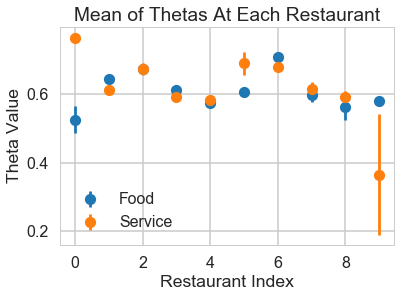

Food Rankings:
1 WTSOPGECPOmq-PUxNiHptQ 0.7086671077134284
2 cSA2pB43cv71ffdIvaEodA 0.6743205005002856
3 q1ZQlDDASrPwYPxbWqtvZw 0.6438278285031428
4 LE5yuBdBkTDMTbXkVQbfaw 0.6116984813082856
5 UtbvcvXWLCZX75g_KtMW2A 0.6053219914834286
6 Hv2GCCnyRRo2XxF9XJpK6g 0.597415266210857
7 K5kU2IN6mXvMo-Cx0oQFZg 0.580008873284
8 jpD9ONjJfx5ishYOx9vU0Q 0.575650385778625
9 nrnnVdMNJHn8H1FtcKeybg 0.5640324687754286
10 q0aoi6vsi9TBU5-k3FfOOw 0.5257729133087499

Service Rankings:
1 q0aoi6vsi9TBU5-k3FfOOw 0.7650361785765001
2 UtbvcvXWLCZX75g_KtMW2A 0.6905712124654286
3 WTSOPGECPOmq-PUxNiHptQ 0.6799607159312858
4 cSA2pB43cv71ffdIvaEodA 0.6731804252696001
5 Hv2GCCnyRRo2XxF9XJpK6g 0.614265816832875
6 q1ZQlDDASrPwYPxbWqtvZw 0.611883382962
7 nrnnVdMNJHn8H1FtcKeybg 0.5918901742563333
8 LE5yuBdBkTDMTbXkVQbfaw 0.5906656346366
9 jpD9ONjJfx5ishYOx9vU0Q 0.5825489597110001
10 K5kU2IN6mXvMo-Cx0oQFZg 0.3657362909419


In [20]:
generate_rankings(df_list_food, df_list_serve)

Shown above are plots of the mean theta values over all reviewers at a given restaurant. We have then ordered the restaurants by their mean predictions to generate a rank-ordering of all of the restaurants.

**Problems:**
Once again, we face several problems by using this method to rank-order the restaurants. First, using this ranking system does not include information about the variance in the mean values across the restaurants. As we saw in the problem in the last homework in the case of the Yelp ratings of Ino's sushi, the variance of a predicted rating can provide a lot of information about the quality of the restaurant, although the direct correlation between rating variance and quality is not a closed form relationship. Additionally, there is the inherent problem in that each reviewer has a different general tendency about the way they score their reviews. In other words, some reviewers are more likely on their own to give a positive rating than the other reviewers, even when faced with the exact same conditions. Therefore, a restaurant that has a low number of reviews suffers from a problem with the bias of the people reviewing their restaurant.


### Extra Credit:

1. Propose a model addressing the weakness of your approach in Part C for the overall quality of food and service for each restaurant given the $\theta$'s. Combine your model for the overall quality with your model for the $\theta$'s. 
2. Implement and use this combined model to estimate the overall quality of food and service for each restaurant.

(Its perfectly ok to just propose and not implement, you'll just get less credit. But please atleast try part 1!)



### Proposals for addressing weaknesses
1. Prior is not representative of the data. Solution: create a prior on the mean value of theta that contains information from the mean value of the minimum and the mean value of the maximum rating score generated by each person. 

2. Some reviewers have natural tendencies in the way they rate restaurants. Solution: weight the contribution of each posterior sample by the average rating of that reviewer to determine if this restaurant is above their average or below their average.

3. (Not implemented) While this model is on the reviewers, what we really care about at the end of the day is the restaurants, so we should be constructing a model to directly output scores for each restaurant instead. Solution: create mean values for each of the restaurants across all of the reviews and throw this into the model as the observed data. We would also have to make adjustments to the standard deviation of the model by using the standard deviation of these new means.

### Proposal Model 1: Uniform prior on mu that is between the mean value of min and the mean value of max

In [21]:
# Proposal Model 1: Prior on mu that incorporates the possibility of min and max values 
def perform_sampling_rest_2(data_input):
    J = data_input.shape[0]
    
    # Get the mean of the min and the max scores:
    minmean = data_input['min'].mean()
    maxmean = data_input['max'].mean()
    
    # Create model
    with pm.Model() as review_model:
        minscore = pm.Normal('pmin', mu=minmean, sd=.2)
        maxscore = pm.Normal('pmax', mu=maxmean, sd=.2)
        mu = pm.Deterministic('mu', (minscore+maxscore)/2)
        tau = pm.HalfCauchy('tau', beta=.15) # This is SD of theta
        nu = pm.Normal('nu', mu=0, sd=1, shape=J) # Keep this as N(0,1)
        theta = pm.Deterministic('theta', mu + tau * nu)
        obs = pm.Normal('obs', mu=theta, sd=data_input['stderr'], observed=data_input['mean'])
        
    # Sample with pymc3
    with review_model:
        traces = pm.sample(5000, init=None, njobs=2, tune=500)
        
    # Calculate the theta mean and variance:
    thmean = traces['theta'].mean(axis=0)
    thvar = traces['theta'].var(axis=0)
    
    return (traces, thmean, thvar, review_model)

In [22]:
# Do sampling on a few of the same restaurants:
# Initialize storage dataframe
df_list_food_PM1 = []
df_list_serve_PM1 = []

num_rest=3

# Loop over all of these RIDs
for i, rid_in in enumerate(rids[0:num_rest]):
    # Do the food one:
    data_food = rest_data[(rest_data['topic']==0) & (rest_data['rid']==rid_in)]
    _, thm_f, thv_f, _ = perform_sampling_rest(data_food)
    # Concatentate the original and the estimated data
    df_f = pd.DataFrame(data={'th_mean': thm_f, 'th_var': thv_f})
    data_food.reset_index(drop=True, inplace=True)
    df_f.reset_index(drop=True, inplace=True)
    data_out_food = pd.concat([data_food,df_f], axis=1)
    df_list_food_PM1.append(data_out_food)
    
    # Do the service one:
    data_serve = rest_data[(rest_data['topic']==1) & (rest_data['rid']==rid_in)]
    _, thm_s, thv_s, _ = perform_sampling_rest(data_serve)
    # Concatentate the original and the estimated data
    df_s = pd.DataFrame(data={'th_mean': thm_s, 'th_var': thv_s})
    data_serve.reset_index(drop=True, inplace=True)
    df_s.reset_index(drop=True, inplace=True)
    data_out_serve = pd.concat([data_serve,df_s], axis=1)
    df_list_serve_PM1.append(data_out_serve)
    

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:20<00:00, 274.44it/s]
There were 71 divergences after tuning. Increase `target_accept` or reparameterize.
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:12<00:00, 436.40it/s]
There were 121 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.720668938277, but should be close to 0.8. Try to increase the number of tuning steps.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, tau_log__, mu]
100%|██████████| 5500/5500 [00:09<00:00, 574.43it/s]
Th

Now we can plot the model and do the rankings for the ones that we resampled.

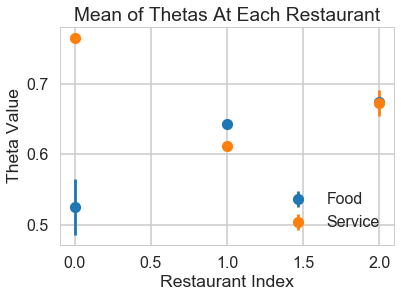

Food Rankings:
1 cSA2pB43cv71ffdIvaEodA 0.6743205005002856
2 q1ZQlDDASrPwYPxbWqtvZw 0.6438278285031428
3 q0aoi6vsi9TBU5-k3FfOOw 0.5257729133087499

Service Rankings:
1 q0aoi6vsi9TBU5-k3FfOOw 0.7650361785765001
2 cSA2pB43cv71ffdIvaEodA 0.6731804252696001
3 q1ZQlDDASrPwYPxbWqtvZw 0.611883382962


In [23]:
generate_rankings(df_list_food_PM1, df_list_serve_PM1)

### Proposal Model 2: Weighting the posterior samples by the average tendencies of the reviewers
Use the original data, and throw it into the ranking function. With the "adjust=1" flag, we are adjusting the score predictions based on the ratio of this reviewer's score of this particular review to their historical average score across all reviews that they have filled out. In other words, if this review is generally of lower score (in terms of stars) than their average, we are bumping down the rating score even further. If the review is generally of higher score than what their average is, we are bumping this rating up.

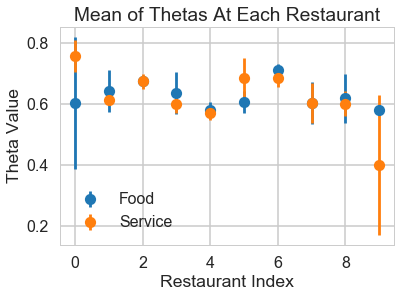

Food Rankings:
1 WTSOPGECPOmq-PUxNiHptQ 0.7120927129907612
2 cSA2pB43cv71ffdIvaEodA 0.6738954445967476
3 q1ZQlDDASrPwYPxbWqtvZw 0.6421824701947854
4 LE5yuBdBkTDMTbXkVQbfaw 0.635307019829394
5 nrnnVdMNJHn8H1FtcKeybg 0.6178867252661764
6 UtbvcvXWLCZX75g_KtMW2A 0.6061339340824533
7 q0aoi6vsi9TBU5-k3FfOOw 0.6035258560967234
8 Hv2GCCnyRRo2XxF9XJpK6g 0.6020427072647799
9 K5kU2IN6mXvMo-Cx0oQFZg 0.5799207335487784
10 jpD9ONjJfx5ishYOx9vU0Q 0.579310779460855

Service Rankings:
1 q0aoi6vsi9TBU5-k3FfOOw 0.7559519047725218
2 WTSOPGECPOmq-PUxNiHptQ 0.6837076408676793
3 UtbvcvXWLCZX75g_KtMW2A 0.6834219548226201
4 cSA2pB43cv71ffdIvaEodA 0.6740788914383316
5 q1ZQlDDASrPwYPxbWqtvZw 0.611883382962
6 Hv2GCCnyRRo2XxF9XJpK6g 0.6024194541041905
7 LE5yuBdBkTDMTbXkVQbfaw 0.6000918213512636
8 nrnnVdMNJHn8H1FtcKeybg 0.6000775312787018
9 jpD9ONjJfx5ishYOx9vU0Q 0.5708925081071445
10 K5kU2IN6mXvMo-Cx0oQFZg 0.39963980818154693


In [24]:
generate_rankings(df_list_food, df_list_serve, adjust=1)